##### 04 - Baseline TF-IDF + Logistic Regression

This notebook trains a baseline text classifier on products_with_splits.parquet using:
* TF-IDF features on product_text_norm
* LogisticRegression for fashion vs non-fashion
* train / val / test splits defined earlier

In [3]:
# Create train / val / test DataFrames and check class balance in each split

import pandas as pd

df_train = df[df["split"] == "train"].copy()
df_val   = df[df["split"] == "val"].copy()
df_test  = df[df["split"] == "test"].copy()

print("Shapes:")
print("  train:", df_train.shape)
print("  val  :", df_val.shape)
print("  test :", df_test.shape)


def print_class_balance(name: str, subdf: pd.DataFrame) -> None:
    counts = subdf["label"].value_counts().sort_index()
    pct = subdf["label"].value_counts(normalize=True).sort_index() * 100
    print(f"\nClass balance in {name} (0=non-fashion, 1=fashion):")
    for k in counts.index:
        print(f"  label={k}: {counts[k]} rows ({pct[k]:.2f}%)")


print_class_balance("train", df_train)
print_class_balance("val", df_val)
print_class_balance("test", df_test)

df_train[["product_text_raw", "product_text_norm", "label"]].head(5)

Shapes:
  train: (13961, 10)
  val  : (3262, 10)
  test : (2544, 10)

Class balance in train (0=non-fashion, 1=fashion):
  label=0: 2246 rows (16.09%)
  label=1: 11715 rows (83.91%)

Class balance in val (0=non-fashion, 1=fashion):
  label=0: 474 rows (14.53%)
  label=1: 2788 rows (85.47%)

Class balance in test (0=non-fashion, 1=fashion):
  label=0: 445 rows (17.49%)
  label=1: 2099 rows (82.51%)


,product_text_raw,product_text_norm,label
0,001B 3000A Car Jump Starter Battery Pack (up t...,001b 3000a car jump starter battery pack up to...,0
1,"012 Jump Starter Battery Pack, 4000A Peak Car ...",012 jump starter battery pack 4000a peak car b...,0
3,1-2 Pairs 925 Sterling Silver Mens Earrings Cu...,1 2 pairs 925 sterling silver mens earrings cu...,1
4,"1/2"""" x 18"""" Zirconia Sanding Belts for Belt S...",1 2 x 18 zirconia sanding belts for belt sande...,0
5,"1.5 Gram x 50 Vial Convenient Super Glue, Wegl...",1 5 gram x 50 vial convenient super glue wegla...,0


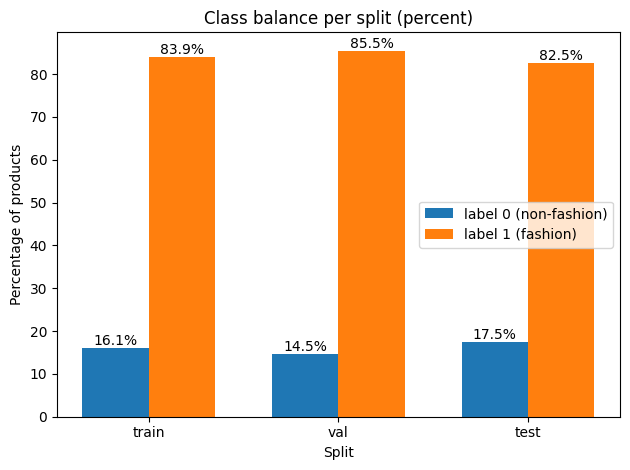

In [7]:
# Visualize class balance per split (percentages)

import matplotlib.pyplot as plt

def get_percentages(subdf: pd.DataFrame):
    pct = subdf["label"].value_counts(normalize=True).sort_index() * 100
    # Ensure both classes 0 and 1 exist
    return pct.get(0, 0.0), pct.get(1, 0.0)

train_p0, train_p1 = get_percentages(df_train)
val_p0, val_p1     = get_percentages(df_val)
test_p0, test_p1   = get_percentages(df_test)

splits = ["train", "val", "test"]
p0_values = [train_p0, val_p0, test_p0]
p1_values = [train_p1, val_p1, test_p1]

x = range(len(splits))
bar_width = 0.35

plt.figure()

bars0 = plt.bar(
    [i - bar_width / 2 for i in x],
    p0_values,
    width=bar_width,
    label="label 0 (non-fashion)",
)

bars1 = plt.bar(
    [i + bar_width / 2 for i in x],
    p1_values,
    width=bar_width,
    label="label 1 (fashion)",
)

plt.xticks(list(x), splits)
plt.ylabel("Percentage of products")
plt.xlabel("Split")
plt.title("Class balance per split (percent)")

# Add percentage labels on top of each bar
for bars in (bars0, bars1):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
        )

plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [5]:
# Prepare features (X) and labels (y) for each split

X_train = df_train["product_text_norm"].values
y_train = df_train["label"].values

X_val = df_val["product_text_norm"].values
y_val = df_val["label"].values

X_test = df_test["product_text_norm"].values
y_test = df_test["label"].values

print("Example training texts:")
for i in range(5):
    print(f"- [{y_train[i]}] {X_train[i]}")

Example training texts:
- [0] 001b 3000a car jump starter battery pack up to 9 0l gas and 7 0l diesel engine 12v car battery charger jump box with usb 3 0 power bank
- [0] 012 jump starter battery pack 4000a peak car battery charger jump starter for up to 10 0l gas or 8 0l diesel engine 12v car jumper starter portable with full lcd screen led light usb
- [1] 1 2 pairs 925 sterling silver mens earrings cubic zirconia halo stud earrings for men 18k gold plated heart round square cut cz stud earrings set for women men
- [0] 1 2 x 18 zirconia sanding belts for belt sander 32pcs 8 each of 40 60 80 120 assorted grits 1 2 x 18 inch sanding belts for air belt sander woodworking metal polishing derusting 32 pack
- [0] 1 5 gram x 50 vial convenient super glue weglau all purpose adhesive super glue bulk instant bonding for bonding glass leather metal wood plastic silicone rubber jewelry


In [8]:
# Baseline pipeline: TF-IDF vectorizer + Logistic Regression classifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# We start with a reasonable baseline: unigrams + bigrams, min_df to drop rare noise.
# These choices follow common text-classification setups in the literature/docs.
tfidf_logreg = Pipeline(
    steps=[
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 2),
                min_df=5,
                max_df=0.9,
            ),
        ),
        (
            "clf",
            LogisticRegression(
                solver="liblinear",  # good for smaller-ish datasets, L2 penalty
                class_weight=None,   # we will first see how the skew looks without reweighting
                max_iter=1000,
            ),
        ),
    ]
)

print("Fitting TF-IDF + Logistic Regression on train split...")
tfidf_logreg.fit(X_train, y_train)
print("Done.")

Fitting TF-IDF + Logistic Regression on train split...
Done.



=== Train ===
Accuracy: 0.9764
Classification report:
              precision    recall  f1-score   support

           0     0.9601    0.8900    0.9238      2246
           1     0.9792    0.9929    0.9860     11715

    accuracy                         0.9764     13961
   macro avg     0.9697    0.9415    0.9549     13961
weighted avg     0.9761    0.9764    0.9760     13961

Confusion matrix (rows=true, cols=pred):
[[ 1999   247]
 [   83 11632]]


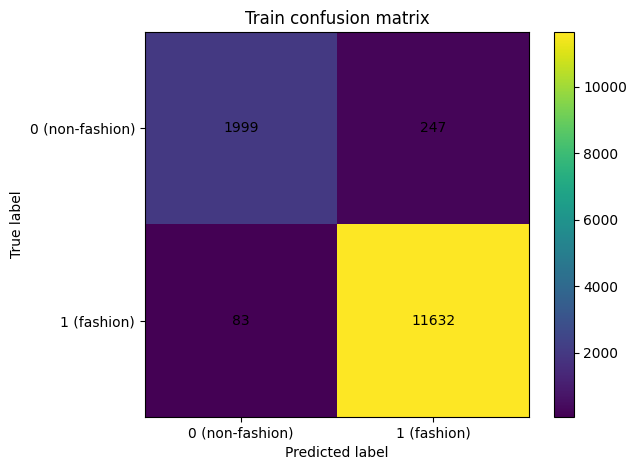


=== Validation ===
Accuracy: 0.9635
Classification report:
              precision    recall  f1-score   support

           0     0.9587    0.7827    0.8618       474
           1     0.9642    0.9943    0.9790      2788

    accuracy                         0.9635      3262
   macro avg     0.9614    0.8885    0.9204      3262
weighted avg     0.9634    0.9635    0.9620      3262

Confusion matrix (rows=true, cols=pred):
[[ 371  103]
 [  16 2772]]


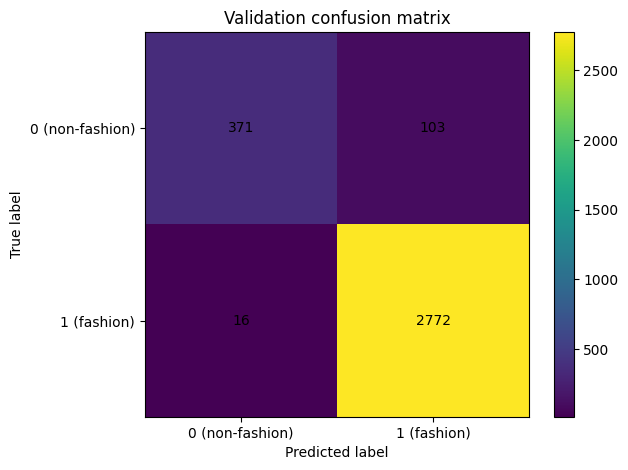

In [9]:
# Evaluate baseline model on train and validation splits

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)
import numpy as np
import matplotlib.pyplot as plt


def evaluate_split(name, X, y_true):
    y_pred = tfidf_logreg.predict(X)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    # Simple confusion matrix heatmap
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
    plt.yticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # Add counts to the cells
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                str(cm[i, j]),
                ha="center",
                va="center",
            )

    plt.tight_layout()
    plt.grid(False)
    plt.show()


evaluate_split("Train", X_train, y_train)
evaluate_split("Validation", X_val, y_val)

#### Above results
	•	Train accuracy: 0.976
	•	Val accuracy: 0.964
    High train, high validation, with a small gap means good generalization - so no overfitting

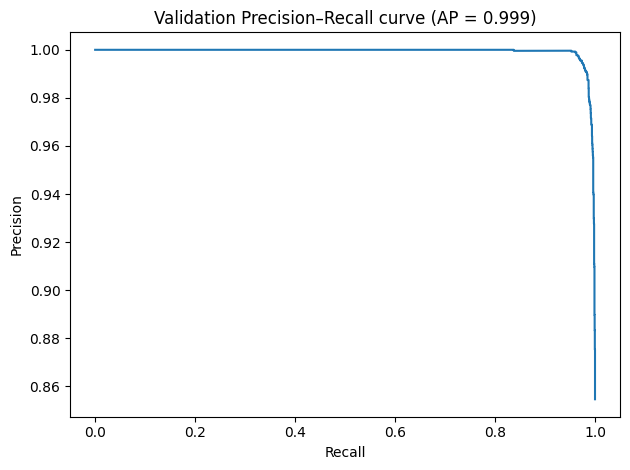

In [10]:
# Precision–recall curve on validation set

from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for class 1 (fashion)
val_probs = tfidf_logreg.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, val_probs)
ap = average_precision_score(y_val, val_probs)

plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Validation Precision–Recall curve (AP = {ap:.3f})")
plt.grid(False)
plt.tight_layout()
plt.show()

#### Note to self
*	precision = of the items I called fashion, how many truly were fashion?
*	recall = of all the true fashion items, how many did I catch?

#### Results from observing the metrics

	*	The label distribution (84% fashion) inflates plain accuracy a bit. That’s why we look at precision/recall per class, not just overall accuracy.
	*	Non-fashion recall is only ~78% on val, so there is still room to improve if false positives are costly in our application, as this is classification is the first step in building a taxonomy.
	* we want to minimize false positives for “fashion”, more willing to tolerate some false negatives for “fashion”
	* care more about precision for the “fashion” class (label 1) than about recall for fashion (High precision = when we call something fashion, it really is fashion)
	*	The model may struggle more on edge cases (e.g., ambiguous items that overlap fashion/beauty/other), even if global metrics look great. We’ll see that better when we do manual QA later.

	
	Next
	•	scans thresholds from 0.5 up to, say, 0.99,
	•	prints precision, recall, and false positives for fashion at each,
	•	helps us pick a threshold that gives very high precision for fashion.

In [12]:
# Examine different probability thresholds on the validation set
# to control false positives for "fashion" (label 1).

import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix

thresholds_to_check = np.linspace(0.5, 0.99, 20)

print("Thresh  |  Prec_1  Recall_1  FP_for_1  FN_for_1")
print("--------+----------------------------------------")

for thr in thresholds_to_check:
    y_val_pred_thr = (val_probs >= thr).astype(int)
    prec_1 = precision_score(y_val, y_val_pred_thr, pos_label=1)
    rec_1 = recall_score(y_val, y_val_pred_thr, pos_label=1)

    cm = confusion_matrix(y_val, y_val_pred_thr, labels=[0, 1])
    # cm[0,1] = non-fashion predicted as fashion (false positives for 1)
    # cm[1,0] = fashion predicted as non-fashion (false negatives for 1)
    fp_for_1 = cm[0, 1]
    fn_for_1 = cm[1, 0]

    print(f"{thr:6.2f} |  {prec_1:7.4f}  {rec_1:8.4f}  {fp_for_1:8d}  {fn_for_1:8d}")

Thresh  |  Prec_1  Recall_1  FP_for_1  FN_for_1
--------+----------------------------------------
  0.50 |   0.9642    0.9943       103        16
  0.53 |   0.9689    0.9932        89        19
  0.55 |   0.9763    0.9910        67        25
  0.58 |   0.9801    0.9882        56        33
  0.60 |   0.9839    0.9874        45        35
  0.63 |   0.9874    0.9857        35        40
  0.65 |   0.9906    0.9839        26        45
  0.68 |   0.9924    0.9796        21        57
  0.71 |   0.9945    0.9760        15        67
  0.73 |   0.9949    0.9738        14        73
  0.76 |   0.9956    0.9709        12        81
  0.78 |   0.9978    0.9656         6        96
  0.81 |   0.9989    0.9605         3       110
  0.84 |   0.9993    0.9559         2       123
  0.86 |   0.9996    0.9458         1       151
  0.89 |   0.9996    0.9232         1       214
  0.91 |   0.9996    0.8802         1       334
  0.94 |   1.0000    0.7898         0       586
  0.96 |   1.0000    0.5595         0 

Interpretation of above results and picking a threshold, here is what those columns mean

	•	Thresh: probability cutoff for calling something fashion
	•	Prec_1: precision for fashion at that threshold
	•	Recall_1: recall for fashion at that threshold
	•	FP_for_1: non-fashion items wrongly called fashion
	•	FN_for_1: fashion items missed (called non-fashion)

Following is the threshold i picked 

#### 0.84 looks like a good “business” compromise: almost no non-fashion contamination, and still very high recall for fashion. 
#### I put this 0.84 in the code below and see how it works


=== Validation (threshold = 0.84) ===
Accuracy: 0.9601
Class 0 (non-fashion):
  precision = 0.7867, recall = 0.9958, f1 = 0.8790, support = 474
Class 1 (fashion):
  precision = 0.9992, recall = 0.9541, f1 = 0.9761, support = 2788
Confusion matrix (rows=true, cols=pred):
[[ 472    2]
 [ 128 2660]]


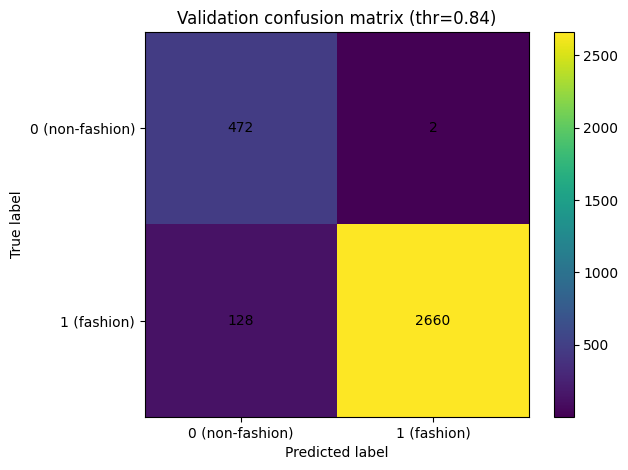


=== Test (threshold = 0.84) ===
Accuracy: 0.9344
Class 0 (non-fashion):
  precision = 0.7317, recall = 0.9865, f1 = 0.8402, support = 445
Class 1 (fashion):
  precision = 0.9969, recall = 0.9233, f1 = 0.9587, support = 2099
Confusion matrix (rows=true, cols=pred):
[[ 439    6]
 [ 161 1938]]


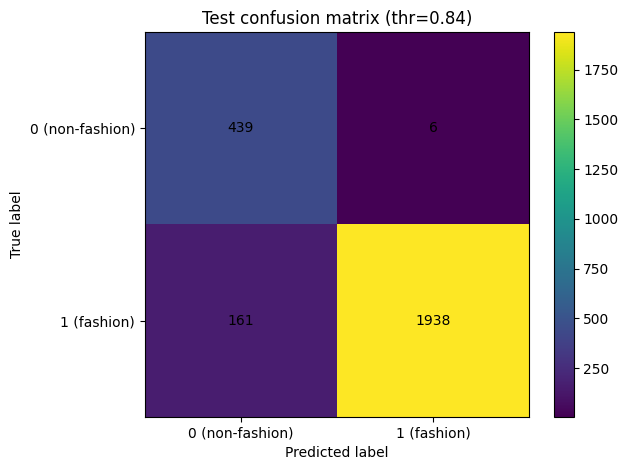

In [14]:
# Evaluate chosen threshold on validation and test, with confusion-matrix plots

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

FASHION_THRESHOLD = 0.84  # from validation sweep


def evaluate_with_threshold_and_plot(name, X, y_true, threshold):
    # Predict with custom threshold
    probs = tfidf_logreg.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1], zero_division=0
    )

    print(f"\n=== {name} (threshold = {threshold:.2f}) ===")
    print(f"Accuracy: {acc:.4f}")
    print("Class 0 (non-fashion):")
    print(f"  precision = {prec[0]:.4f}, recall = {rec[0]:.4f}, "
          f"f1 = {f1[0]:.4f}, support = {support[0]}")
    print("Class 1 (fashion):")
    print(f"  precision = {prec[1]:.4f}, recall = {rec[1]:.4f}, "
          f"f1 = {f1[1]:.4f}, support = {support[1]}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion matrix (rows=true, cols=pred):")
    print(cm)

    # Plot confusion matrix heatmap
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"{name} confusion matrix (thr={threshold:.2f})")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
    plt.yticks(tick_marks, ["0 (non-fashion)", "1 (fashion)"])
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # Add counts into squares
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                str(cm[i, j]),
                ha="center",
                va="center",
            )

    plt.tight_layout()
    plt.grid(False)
    plt.show()

    return cm


cm_val_thr = evaluate_with_threshold_and_plot("Validation", X_val, y_val, FASHION_THRESHOLD)
cm_test_thr = evaluate_with_threshold_and_plot("Test", X_test, y_test, FASHION_THRESHOLD)

#### Baseline logistic regression with tuned threshold (thr = 0.84)

Using TF-IDF + logistic regression and a probability threshold of **0.84** for the "fashion" class:

- **Validation split**
  - Non-fashion (label 0): precision ≈ 0.79, recall ≈ 0.996  
    → only 2 of 474 non-fashion items are incorrectly tagged as fashion.
  - Fashion (label 1): precision ≈ 0.999, recall ≈ 0.95  
    → almost every fashion prediction is truly fashion, while we lose about 5% of fashion items.

- **Test split (held-out months)**
  - Non-fashion (label 0): precision ≈ 0.73, recall ≈ 0.99  
    → 6 of 445 non-fashion items are misclassified as fashion.
  - Fashion (label 1): precision ≈ 0.997, recall ≈ 0.92  
    → predictions labelled "fashion" are almost always correct, with ~8% of fashion items being missed.

This operating point is chosen to **protect downstream taxonomy steps**: we strongly prioritize avoiding non-fashion items being routed into the fashion branch, and accept a modest loss of recall on fashion.

#### Why we changed the decision threshold

The default threshold of 0.5 gave very high overall accuracy, but still allowed a noticeable number of non-fashion items to be classified as fashion. Since this classifier is the first step in a taxonomy, false "fashion" predictions are especially harmful (they send non-fashion products down the wrong branch).

Following standard classification practice, we:

- used the validation set to scan different probability thresholds,
- inspected precision, recall, and false positives for the "fashion" class,
- selected **0.84** as a compromise where:
  - precision for fashion is extremely high (~99–100%),
  - the number of non-fashion items misclassified as fashion is very small,
  - recall for fashion remains above 90% on both validation and test.

This threshold is now the baseline operating point for the logistic regression model.